# Training Convolutional MNIST classifiers in $\omega$-space

Sam Greydanus. June 2017. MIT License.

$$\arg\min_{\mathbf{\omega}}  -\frac{1}{n} \sum_X (y\ln \hat y +(1-y)\ln (1-\hat y)) \quad \mathrm{where} \quad \hat y = f_{NN}(\theta, X) \quad \mathrm{and} \quad \theta = P \omega$$

**Inituitively,** we want to express the parameters, $\theta$, of a neural network as the product of a projector, $P$, and a vector, $\omega$, of trainable parameters that occupy a smaller space (e.g. of dimension 1000, 3000, or 10,000). During training, we'll backprop into and optimize in $\omega$ space.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets, models, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import *

reseed = lambda: np.random.seed(seed=123) ; ms = torch.manual_seed(123) # for reproducibility
reseed()

## Hyperparameters

This gets a little hacky because I'm trying to mimic `argparse`, which I use in `main.py` to set hyperparameters. Doing this is worthwhile because it allows me to keep the rest of the syntax identical between this notebook and the `main.py` file.

In [2]:
class DummyArgparse():
    def __init__(self):
        pass
args = DummyArgparse()

args.fig_dir = 'figures/'      # directory to save figures
args.hidden_dim = 200          # hidden dimension of neural network
args.batch_size = 256          # batch size for training
args.omega_dims = [10000, 3000, 1000, None] # sizes for omega subspaces
args.lr = 3e-3                 # learning rate
args.test_every = 100          # record test accuracy after this number of steps
args.epochs = 100              # number of epochs (...we need a LOT of epochs when optimizing in these subspaces)

# book-keeping
os.makedirs(args.fig_dir) if not os.path.exists(args.fig_dir) else None
args.input_dim = 28**2
args.target_dim = 10
global_step = 0
total_steps = int(60000*args.epochs/args.batch_size)
print("using {} epochs ({} steps)".format(args.epochs, total_steps))

using 100 epochs (23437 steps)


## Data loader
This object is an interface to the PyTorch MNIST utility. It lets us access either the train or test sets, depending on the mode we request. Training samples from the MNIST dataset look like this:

<img src="static/mnist.png" alt="MNIST training samples" style="width: 250px;"/>

In [3]:
# make dataloader
dataloader = Dataloader(args.batch_size, args.input_dim)

## Subspace NN
I could also have written `from subspace_nn import SubspaceNN`, but this class is the meat of this project so I wanted to show it off.

**Overview.** If the `omega_dim` parameter is not set to `None`, the class will initialize its trainable parameters in a subspace of dimension $\omega$ and construct a projector, $P$, which maps from $\omega$-space to $\theta$-space:
$$\theta = P \omega$$
The class will initialize its trainable parameters in $\theta$-space as usual if `omega_dim` is `None`.

**Initialization.** The $\omega$ subspace makes initialization tricky. First, we perform initialization in $\theta$-space as usual, then use the initialized vector, $\theta_i$ as the first column vector in the projector $P$. We obtain the other columns of $P$ using [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition) to obtain an orthonormal basis. Finally, we set all entries of the $\omega_i$ vector to $0$ except the first, which we set to $a = \theta_i[0] / P[0,0]$. We chose $a$ in this way because each column vector of $P$ has been normalized and therefore the first column vector differs from $\theta_i$ by a factor of $a$.

**Feedforward.** The feedforward part looks the same regardless of whether we're training in $\omega$-space or $\theta$-space.

In [4]:
class SubspaceConvNN(nn.Module):
    def __init__(self, batch_size, output_dim, omega_dim=None):
        super(SubspaceConvNN, self).__init__()
        #param_meta maps each param to (dim1, dim2, initial_stdev)
        self.batch_size = batch_size
        self.omega_dim = omega_dim
        self.param_meta = {'W1': [(10,1,5,5),  0.005],  'b1': [(10,), 0.0],\
                           'W2': [(20,10,5,5), 0.005], 'b2': [(20,), 0.0], \
                           'W3': [(320,50),    0.005], 'b3': [(50,), 0.0],\
                           'W4': [(50,10),     0.005], 'b4': [(10,), 0.0]}
        self.names = [k for k in self.param_meta.keys()]
        self.counts = [np.cumprod(self.param_meta[n][0])[-1] for n in self.names]
        self.slices = np.cumsum([0] + self.counts)
        self.theta_dim = int(self.slices[-1])
        
        self.init_param_space()
        self.drop2d = nn.Dropout2d()
        print('model summary:\n\tthis model\'s omega space has {} parameters'.format(self.omega_dim))
        print('\tthis model\'s theta space has {} parameters'.format(self.theta_dim))
        
    def init_param_space(self):
        # initialize and concat
        flat_params = [np.random.randn(self.counts[i],1)*self.param_meta[n][1] for i, n in enumerate(self.names)]
        theta_init = np.concatenate(flat_params, axis=0)
        if self.omega_dim is None:
            self.flat_theta = nn.Parameter(torch.Tensor(theta_init), requires_grad=True)
        else:
            random_init = np.random.randn(self.theta_dim, self.omega_dim-1)

            # this is where the subspace magic happens
            A = np.concatenate((theta_init, random_init), axis=1) # first column is initializations
            p, _ = np.linalg.qr(A)
            self.P = Variable(torch.Tensor(p), requires_grad=False)

            omega = torch.zeros(self.omega_dim,1)
            omega[0] = theta_init[0,0] / p[0,0] # multiply the first column by this to get theta_init values
            self.omega = nn.Parameter(omega, requires_grad=True)
            
    def get_flat_theta(self):
        return self.flat_theta if self.omega_dim is None else self.P.mm(self.omega).resize(self.theta_dim)
    
    def param_count(self):
        return sum([np.prod(p.size()) for p in self.parameters()])

    def forward(self, X):
        flat_theta = self.get_flat_theta() # project parameters into full space
        thetas = {n: flat_theta[self.slices[i]:self.slices[i+1]] for i, n in enumerate(self.names)}
        T = {k : v.resize(*self.param_meta[k][0]) for k, v in thetas.items()}
        
        X = X.resize(self.batch_size, 1, 28, 28)
        z1 = F.conv2d(X, T['W1'], bias=T['b1'])
        h1 = F.relu(F.max_pool2d(z1, 2))
        
        z2 = self.drop2d( F.conv2d(h1, T['W2'], bias=T['b2']) )
        h2 = F.relu(F.max_pool2d(z2, 2)).view(-1, 320)
        
        h3 = F.dropout( F.relu( h2 @ T['W3'] + T['b3'] ), training=self.training)
        return F.log_softmax( h3 @ T['W4'] + T['b4'] )

## Train several models
Train an MNIST classifier in $\omega$ spaces of dimensions $[1000, 3000, 10000]$ as well as in full theta-space. Save losses and test accuracies for each of these training processes. We'll plot them later to compare the convergence properties of the network for various dimensions of $\omega$.

In [5]:
# train models with different omega subspace sizes, saving loss and accuracies for each
model = None
histories = []
for i, omega_dim in enumerate(args.omega_dims):
    reseed()
    model = SubspaceConvNN(args.batch_size, args.target_dim, omega_dim=omega_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.99), weight_decay=0)
    h = train(dataloader, model, optimizer, global_step, total_steps, args.test_every)
    histories.append(h)

model summary:
	this model's omega space has 10000 parameters
	this model's theta space has 21840 parameters
	training...
model summary:437 | accuracy: 98.7981% (9864/9984) | loss: 0.1400
	this model's omega space has 3000 parameters
	this model's theta space has 21840 parameters
	training...
model summary:437 | accuracy: 96.9952% (9684/9984) | loss: 0.3535
	this model's omega space has 1000 parameters
	this model's theta space has 21840 parameters
	training...
model summary:437 | accuracy: 93.4996% (9335/9984) | loss: 0.7842
	this model's omega space has None parameters
	this model's theta space has 21840 parameters
	training...


## Compare losses

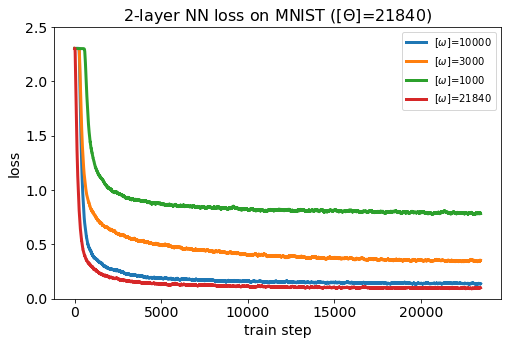

In [6]:
f2 = plt.figure(figsize=[8,5])
for i, omega_dim in enumerate(args.omega_dims):
    omega_dim = model.theta_dim if omega_dim is None else omega_dim
    loss_hist = histories[i][0]
    xy = np.stack(loss_hist)
    plt.plot(xy[:,0], xy[:,1], linewidth=3.0, label='[$\omega$]={}'.format(omega_dim))

title = "2-layer NN loss on MNIST ([$\Theta$]={})".format(model.theta_dim)
plt.title(title, fontsize=16)
plt.xlabel('train step', fontsize=14) ; plt.setp(plt.gca().axes.get_xticklabels(), fontsize=14)
plt.ylabel('loss', fontsize=14) ; plt.setp(plt.gca().axes.get_yticklabels(), fontsize=14)
plt.ylim([0,2.5])
plt.legend()

plt.show() ; f2.savefig('./{}conv-subspace-loss.png'.format(args.fig_dir), bbox_inches='tight')

## Compare accuracies

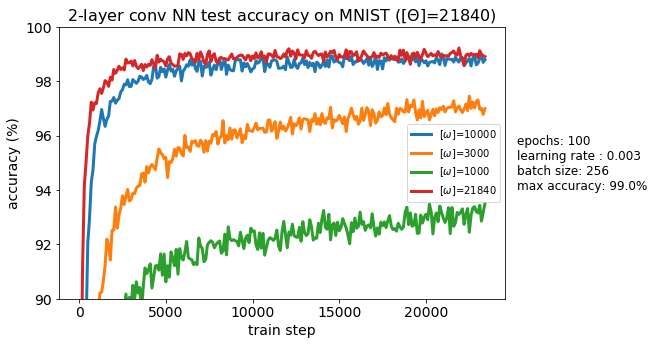

In [11]:
f3 = plt.figure(figsize=[8,5])
for i, omega_dim in enumerate(args.omega_dims):
    omega_dim = model.theta_dim if omega_dim is None else omega_dim
    acc_hist = histories[i][1]
    xy = np.stack(acc_hist)
    plt.plot(xy[:,0], xy[:,1], linewidth=3.0, label='[$\omega$]={}'.format(omega_dim))

title = "2-layer conv NN test accuracy on MNIST ([$\Theta$]={})".format(model.theta_dim)
plt.title(title, fontsize=16)
plt.xlabel('train step', fontsize=14) ; plt.setp(plt.gca().axes.get_xticklabels(), fontsize=14)
plt.ylabel('accuracy (%)', fontsize=14) ; plt.setp(plt.gca().axes.get_yticklabels(), fontsize=14)

results_msg = 'epochs: {}\nlearning rate : {}\nbatch size: {}\nmax accuracy: {:.1f}%'\
    .format(args.epochs, args.lr, args.batch_size, acc_hist[-1][-1])
f3.text(0.92, .50, results_msg, ha='left', va='center', fontsize=12)
plt.ylim([90,100])
plt.legend()

plt.show() ; f3.savefig('./{}conv-subspace-acc.png'.format(args.fig_dir), bbox_inches='tight')